In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)
from scipy.interpolate import CubicSpline
from xai.data import load_SL_data, preprocess_data
from xai.pdp import PDPEnsembler, PDPPlotter
from xai.models import DenseNeuralNetwork
import numpy as np
from matplotlib.colors import LogNorm
import pandas as pd
from tensorflow.keras.models import load_model
from os.path import join
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from xai.models import set_global_determinism
from sklearn.metrics import mean_squared_error
import os
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import tensorflow_probability as tfp

from sklearn.inspection import partial_dependence

In [2]:
def preprocess_data(data, input_features, output_features, scaler_type="standard"):
    """
    Function to select features and scale data for ML
    Args:
        data (dictionary of dataframes for training and validation data):
        input_features (list): Input features
        output_features (list): Output features
        scaler_type: Type of scaling to perform (supports "standard" and "minmax")

    Returns:
        Dictionary of scaled data, dictionary of scaler objects
    """
    scalar_obs = {"minmax": MinMaxScaler, "standard": StandardScaler}
    scalers, scaled_data = {}, {}

    scalers["input"], scalers["output"] = scalar_obs[scaler_type]((0.1, 1.1)), scalar_obs[scaler_type]((0.1, 1.1))
    scaled_data["train_x"] = pd.DataFrame(scalers["input"].fit_transform(data["train"][input_features]),
                                          columns=input_features)
    scaled_data["val_x"] = pd.DataFrame(scalers["input"].transform(data["val"][input_features]), columns=input_features)
    scaled_data["train_y"] = pd.DataFrame(
        scalers["output"].fit_transform(data["train"][output_features].values.reshape(-1, len([output_features]))),
        columns=[output_features])
    scaled_data["val_y"] = pd.DataFrame(
        scalers["output"].transform(data["val"][output_features].values.reshape(-1, len([output_features]))),
        columns=[output_features])

    return scaled_data, scalers

In [3]:
def NLL(y_true, y_pred, reduce=True):
    
    A = 0.5 * tf.math.log(2 * np.pi * y_pred[:, 1] + 1e-12) 
    B = ((y_true[:, 0] - y_pred[:, 0]) ** 2) / (2 * y_pred[:, 1] ** 2 + 1e-12)
    nll = A + B
    
    return tf.reduce_mean(nll) if reduce else nll

# def my_nll(y_true, y_pred, eps=1e-12):
    
#     mu, sigma = y_pred[:, 0], y_pred[:, 1]
#     A = np.log(sigma ** 2) / 2
#     B = ((y_true[:, 0] - mu) ** 2) / (sigma ** 2)
    
#     return np.mean(A + B + eps)

# def negative_loglikelihood(targets, estimated_distribution):
#     return -estimated_distribution.log_prob(targets)

# def nll_gaussian(y_pred_mean,y_pred_sd,y_test):

#     ## element wise square
#     square = tf.square(y_pred_mean - y_test)## preserve the same shape as y_pred.shape
#     ms = tf.add(tf.divide(square,y_pred_sd), tf.log(y_pred_sd))
#     ## axis = -1 means that we take mean across the last dimension 
#     ## the output keeps all but the last dimension
#     ## ms = tf.reduce_mean(ms,axis=-1)
#     ## return scalar
#     ms = tf.reduce_mean(ms)
#     return(ms)


# def Gaussian_NLL(y, y_pred, reduce=True):
#     ax = list(range(1, len(y.shape)))

#     logprob = -tf.math.log(y_pred[:, 1]) - 0.5*tf.math.log(2*np.pi) - 0.5*((y-y_pred[:, 0])/y_pred[:, 1])**2
#     loss = tf.reduce_mean(-logprob, axis=ax)
#     return tf.reduce_mean(loss) if reduce else loss

Train an ensemble of parametric models to predict parameters of a normal distribution (mu, sigma) for all three target types (Friction velocity, Sensible heat, and Latent heat) independently.

In [4]:
%%time

data = load_SL_data(data_path='/glade/p/cisl/aiml/ai2es/surfacelayer/idaho_derived_data_20210720.csv', val_year=2015)
data['val'] = data['val'].loc['2015-03-19':'2015-12-31']

predictions, models, scalers = {}, {}, {}
n_members = 30
epochs = 40
batch_size = 1024
lr = 0.01
decay = 0.01
loss = NLL
input_cols = ['wind_speed:10_m:m_s-1',
              'potential_temperature_skin_change:10_m:K_m-1',
              'bulk_richardson:10_m:None',
              'mixing_ratio_skin_change:2_m:g_kg-1_m-1']
output_cols = ['friction_velocity:surface:m_s-1', 
               'kinematic_sensible_heat_flux:surface:K_m_s-1', 
               'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']
output_types = ['Friction_velocity', 'Sensible_heat', 'latent_heat']

              

for t, target in zip(output_types, output_cols):
    models[t] = {}
    scalers[t] = {}
    arr = np.zeros(shape=(n_members, len(data['val']), 2))
    scaled_data, scaler = preprocess_data(data=data,
                                       input_features=input_cols,
                                       output_features=target,
                                       scaler_type='minmax')
    scalers[t]["input"] = scaler["input"]
    scalers[t]["output"] = scaler["output"]
    
    for m in range(n_members):
        optimizer = Adam(learning_rate=lr, decay=decay)
        mod_input = Input(shape=4,)
        mod = mod_input
        mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
        mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
        mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
        mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
        mod = Dense(2, activation='sigmoid')(mod)
        mod = Model(mod_input, mod)
        mod.compile(loss=loss, optimizer=optimizer, run_eagerly=False)
        mod.fit(scaled_data['train_x'], scaled_data['train_y'], batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
        mod.dummy_ = "dummy"                ## needed for comatibility with non-sklearn models
        mod._estimator_type = "regressor"   ## needed for comatibility with non-sklearn models
        
        preds = np.array(mod(scaled_data['val_x'].values))
        mu, s = scaler['output'].inverse_transform(preds[:, 0].reshape(-1, 1)).flatten(), preds[:, 1]
        sigma = np.sqrt(s * data['train'][target].values.var())
        arr[m, :, 0] = mu
        arr[m, :, 1] = sigma
        models[t][f"member_{m}"] = mod
        if m % 10 == 0: print(m)
        del mod, mod_input, optimizer
        
    predictions[t] = arr
    
uncertainties = {'Friction_velocity': {'aleatoric': predictions['Friction_velocity'][:, :, 1].mean(axis=0), 'epistemic': predictions['Friction_velocity'][:, :, 0].std(axis=0)},
                 'Sensible_heat': {'aleatoric': predictions['Sensible_heat'][:, :, 1].mean(axis=0), 'epistemic': predictions['Sensible_heat'][:, :, 0].std(axis=0)},
                 'latent_heat': {'aleatoric': predictions['latent_heat'][:, :, 1].mean(axis=0), 'epistemic': predictions['latent_heat'][:, :, 0].std(axis=0)}}

2022-11-18 08:00:58.463875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 08:01:01.349347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


0
10
20
0
10
20
0
10
20
CPU times: user 4min 36s, sys: 27.5 s, total: 5min 3s
Wall time: 3min 46s


Train a simple deterministic MLP with same parameters for comparison. 

In [5]:
%%time  
# Train a single output MLP for comparison
single_output_MLP = {}
single_output_preds = {}
for t, target in zip(output_types, output_cols):
    single_output_MLP[t] = {}
    scaled_data, scaler = preprocess_data(data=data,
                                   input_features=input_cols,
                                   output_features=target,
                                   scaler_type='minmax')
    
    optimizer = Adam(learning_rate=lr, decay=decay)
    mod_input = Input(shape=4,)
    mod = mod_input
    mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
    mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
    mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
    mod = Dense(256, activation='relu', kernel_regularizer=l2(1e-7))(mod)
    mod = Dense(1, activation='linear')(mod)
    mod = Model(mod_input, mod)
    mod.compile(loss='mse', optimizer=optimizer, run_eagerly=False)
    mod.fit(scaled_data['train_x'], scaled_data['train_y'], batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
    single_output_preds[t] = scaler['output'].inverse_transform(mod.predict(scaled_data['val_x'].values))
    single_output_MLP[t] = mod
    del mod, mod_input, optimizer

CPU times: user 9.77 s, sys: 1.16 s, total: 10.9 s
Wall time: 7.22 s


Text(45.0, 0.5, 'Distribution Model')

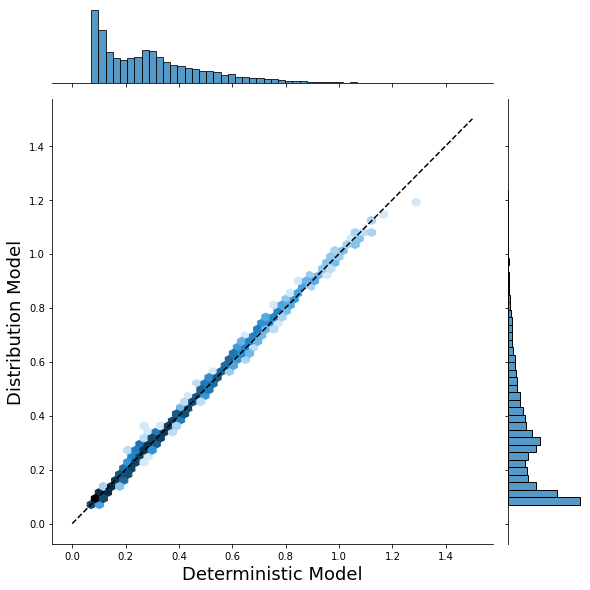

In [6]:
g = sns.jointplot(x=single_output_preds['Friction_velocity'].squeeze(), y=predictions['Friction_velocity'][1, :, 0], kind='hex', norm=LogNorm(), height=8)
plt.plot(np.linspace(0, 1.5, 100), np.linspace(0, 1.5, 100), linestyle='dashed', color='k')
plt.xlabel('Deterministic Model', fontsize=18)
plt.ylabel('Distribution Model', fontsize=18)

Looks as if the distribution model has comparable performance.

In [7]:
dist_metrics = {}
for t, target in zip(output_types, output_cols):
    truth = data['val'][target]
    dist_metrics[t] = []
    for member in range(n_members):
        dist_metrics[t].append(mean_squared_error(truth, predictions[t][member, :, 0]))
    print(f"{t} MSE: \n     minimum mu: {np.min(dist_metrics[t])} \n     maximum mu: {np.max(dist_metrics[t])} \n\
     single output MLP: {mean_squared_error(truth, single_output_preds[t].squeeze())}")

Friction_velocity MSE: 
     minimum mu: 0.005424066953759868 
     maximum mu: 0.006172536074571652 
     single output MLP: 0.00556122903847464
Sensible_heat MSE: 
     minimum mu: 0.0006669987781665436 
     maximum mu: 0.000844016949095813 
     single output MLP: 0.0007358389963447893
latent_heat MSE: 
     minimum mu: 0.00020667607090761088 
     maximum mu: 0.00023587903127912614 
     single output MLP: 0.0002187794361168423


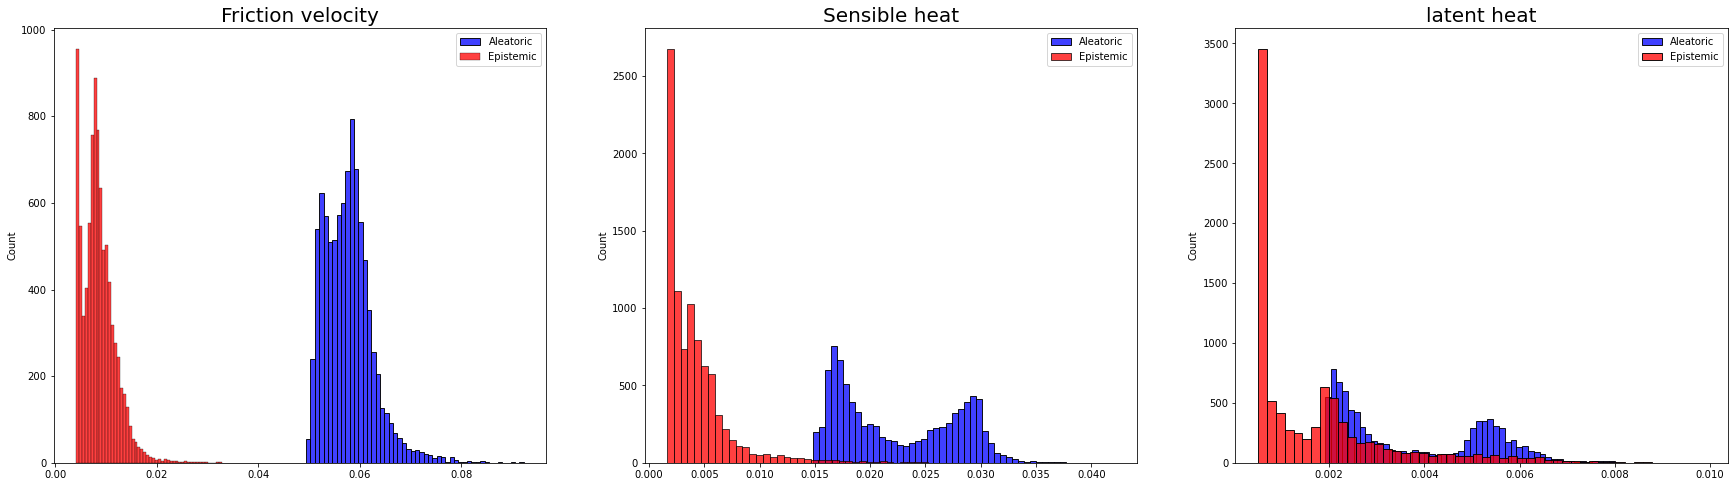

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
targets = list(uncertainties.keys())
for i, ax in enumerate(axes.ravel()):
    target = targets[i]
    sns.histplot(uncertainties[target]['aleatoric'], bins=50, ax=ax, color='b', label='Aleatoric')
    sns.histplot(uncertainties[target]['epistemic'], bins=50, ax=ax, color='r', label='Epistemic')
    ax.set_title(target.replace('_', " "), fontsize=20)
    ax.legend()
# plt.savefig('/glade/scratch/cbecker/SL_uncertainty_hists.png', dpi=300, bbox_inches='tight')

In [9]:
uncertainties[target]['epistemic'].argmin(), uncertainties[target]['aleatoric'].argmin(), uncertainties[target]['epistemic'].argmax(), uncertainties[target]['aleatoric'].argmax()

(295, 8713, 450, 3262)

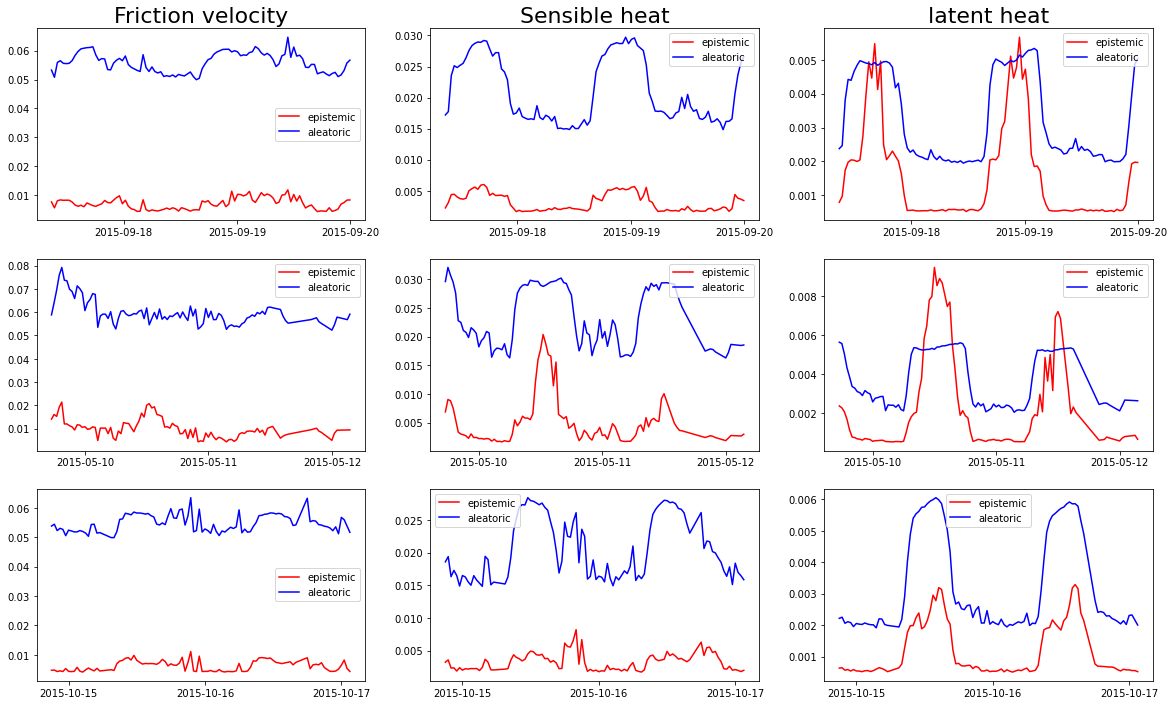

In [10]:
start_i = [7500, 2400, 8700]
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for i in range(3):
    time = data['val'].index[start_i[i]:start_i[i] + 100]
    for j in range(3):
        axes[i, j].plot(time, uncertainties[output_types[j]]['epistemic'][start_i[i]:start_i[i] + 100], label='epistemic', color='r')
        axes[i, j].plot(time, uncertainties[output_types[j]]['aleatoric'][start_i[i]:start_i[i] + 100], label='aleatoric', color= 'b')
        if i == 0:
            axes[i, j].set_title(output_types[j].replace("_", " "), fontsize=22)
        axes[i, j].legend()
        axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(3))

In [11]:
class PDPEnsembler(object):
    """
    A class to calculate ensembles of partial dependence plots, uses sklearns implimentation of partial dependence.
    Does not currently support non-scikit models out of the box. Implimentation for this should come soon.
    Attributes:
         data (np.array): Two dimensional (samples, features) array of scaled input data
         feature_indices (list of int): List of feature indices to calculate partial dependence
         feature_names (list of str): List of features for naming / labeling
         grid_resolution (int): How many times to sample throughout data distribution (linearly interpolated)
         percentiles (tuple: float): Percentiles of data to generate predictions across (must range from 0-1 inclusive)
    """
    def __init__(self, data, feature_indices, feature_names, grid_resolution=25, percentiles=(0.0, 1.0), seed=11):

        self.data = data
        self.feature_indices = feature_indices
        self.feature_names = feature_names
        self.grid_resolution = grid_resolution
        self.percentiles = percentiles
        self.seed = seed

        np.random.seed(self.seed)

    def calc_pdp(self, model, data, feature):
        """
        Calculate partial dependence.
        Args:
            model: Model object
            data (numpy array): scaled input data
            feature (list): list of feature index

        Returns (dictionary):
            Partial dependence, Individual Conditional Expectation for each sample, and grid values used for calculation
        """
        return partial_dependence(model, data, feature, grid_resolution=self.grid_resolution,
                                  percentiles=self.percentiles, kind='both')

    def deep_ensemble_pdp(self, models):
        """
        Calculate Partial dependence for a deep ensemble of models.
        Args:
            models (dict): Model objects
        Returns (dict):
            Partial dependence
        """
        deep_pdp = {}
        for model_name, model in models.items(): 
            for feature, feature_i in zip(self.feature_names, self.feature_indices):
                deep_pdp[f"{feature}_{model_name}"] = self.calc_pdp(model, self.data, [feature_i])

        return deep_pdp

    def mc_dropout_pdp(self, model, n):
        """
        Calculate Partial dependence for a model using Monte Carlo dropout
        Args:
            model: Model object
            n: Number of prediction tasks for Monte Carlo method
        Returns (dict):
            Partial dependence
        """
        mc_pdp = {}

        for i in range(n):

            for feature in self.feature_indices:
                mc_pdp[f"mc_{i}_{self.feature_names[feature]}"] = self.calc_pdp(model, self.data, [feature])

        return mc_pdp

    def bootstrapped_pdp_ensemble(self, model, n_bootstraps):
        """
        Calculate Partial dependence for a single model bootstrapping over the input data
        Args:
            model: Model object
            n_bootstraps: Number of bootstraps to perform
        Returns (dict):
            Partial dependence
        """
        bs_pdp = {}
        for i in range(n_bootstraps):

            for feature in self.feature_indices:
                samples = np.random.choice(np.arange(len(self.data)), size=len(self.data), replace=True)

                bs_pdp[f"bs_{i}_{self.feature_names[feature]}"] = self.calc_pdp(model, self.data[samples], [feature])

        return bs_pdp

In [12]:
%%time
E = PDPEnsembler(data=scaled_data['val_x'].values,
                 feature_indices=np.arange(4),
                 feature_names=input_cols)
FV_pdps = E.deep_ensemble_pdp(models["Friction_velocity"])
SH_pdps = E.deep_ensemble_pdp(models["Sensible_heat"])
LH_pdps = E.deep_ensemble_pdp(models["latent_heat"])

CPU times: user 40min 58s, sys: 4min 9s, total: 45min 8s
Wall time: 33min 58s


In [13]:
# plt.plot(SH_pdps['bulk_richardson:10_m:None_member_11']['individual'].mean(axis=(0, 1)))

In [14]:
# for i in range(895):
#     plt.plot(SH_pdps['bulk_richardson:10_m:None_member_11']['individual'][1, i, :])
# SH_pdps['bulk_richardson:10_m:None_member_11']['individual'].shape

In [15]:
# plt.plot(SH_pdps['bulk_richardson:10_m:None_member_11']['individual'][, 542, 0])

In [17]:
# data_var = data['train'][target].values.var()
# data_var

In [103]:
np.sqrt(pdps[f'{feature}_member_{i}']['individual'][1] * data['train'][target].values.var()).mean(axis=0)

array([0.05300557, 0.05359771, 0.05454546, 0.05612399, 0.0582201 ,
       0.06058817, 0.06267244, 0.06438316, 0.06581537, 0.06707711,
       0.06827029, 0.06940766, 0.07041211, 0.07127611, 0.07190865,
       0.07243164, 0.07292072, 0.07337686, 0.07376847, 0.0741101 ,
       0.07441425, 0.07452358, 0.07427196, 0.07385746, 0.07314287],
      dtype=float32)

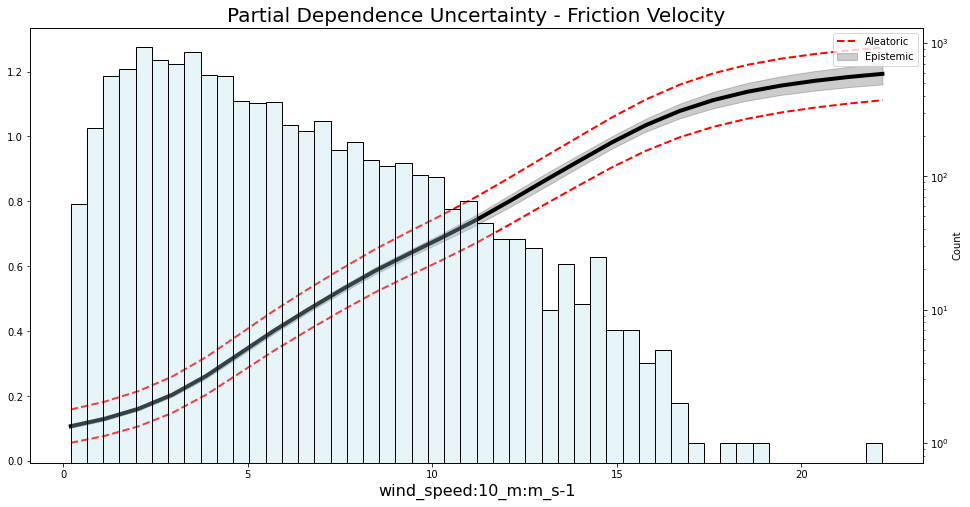

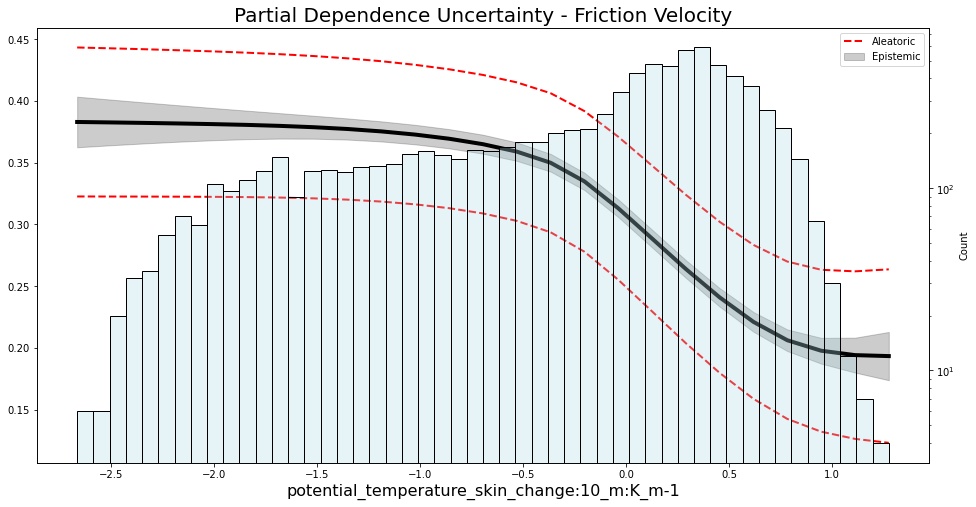

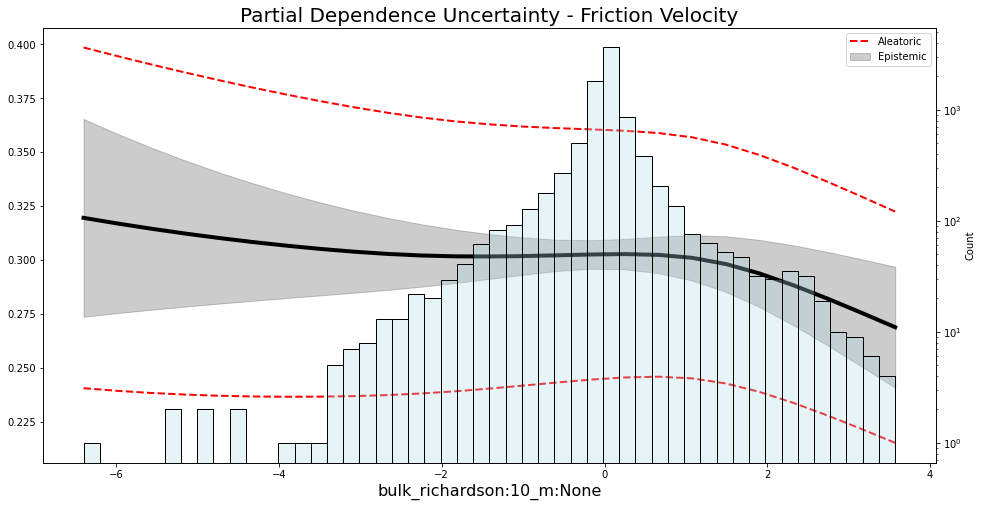

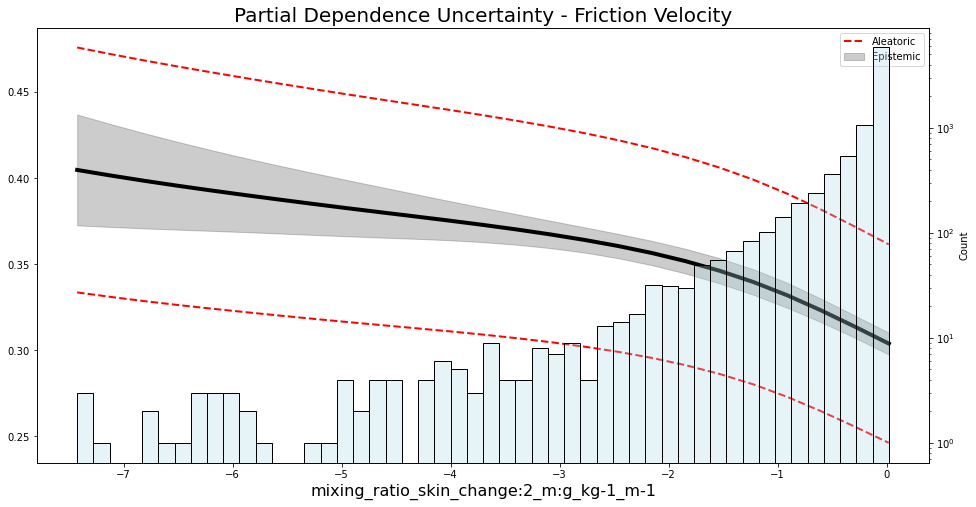

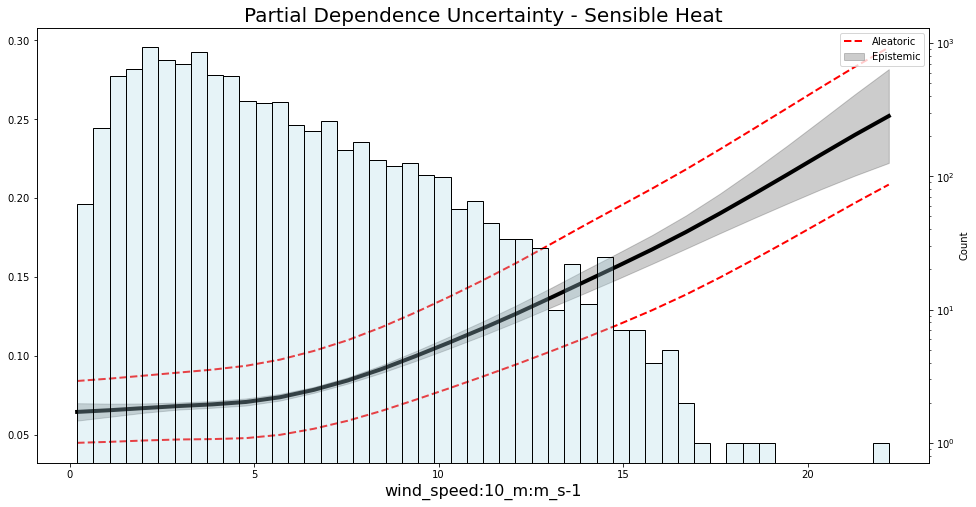

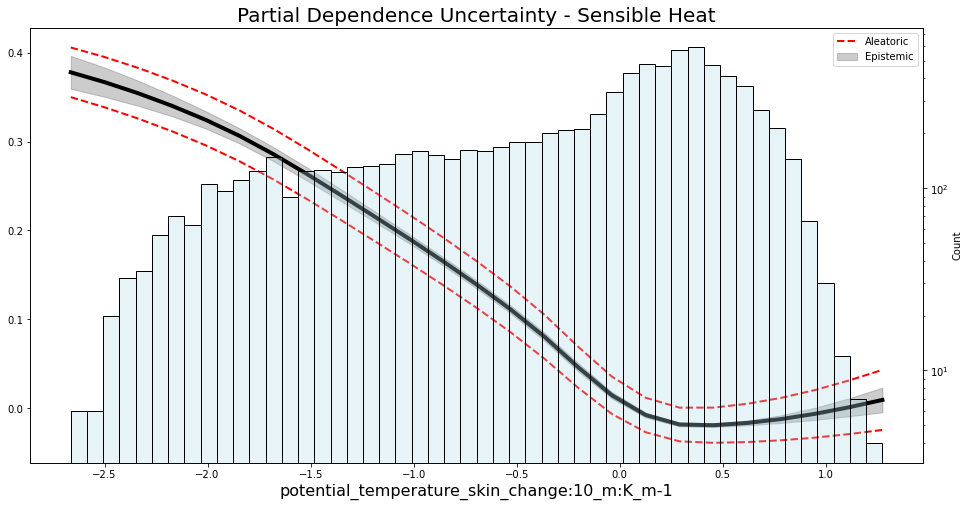

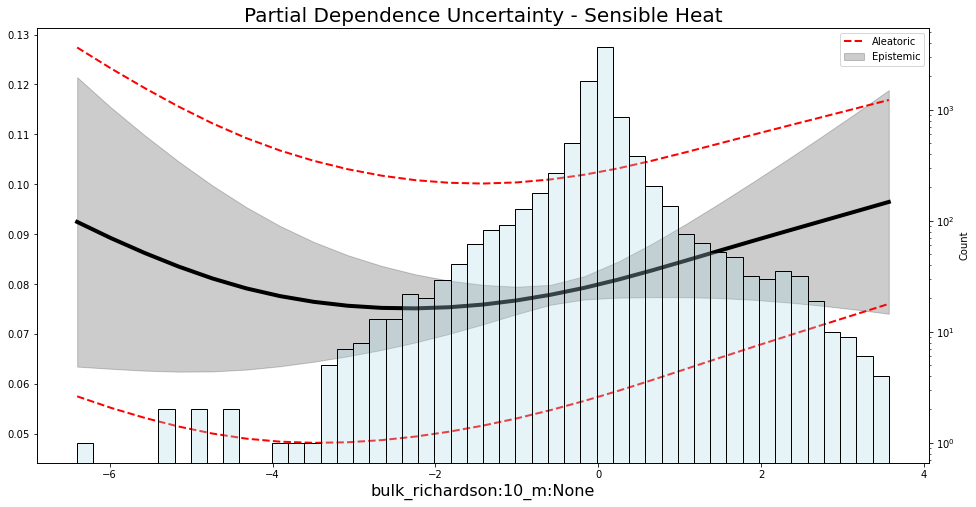

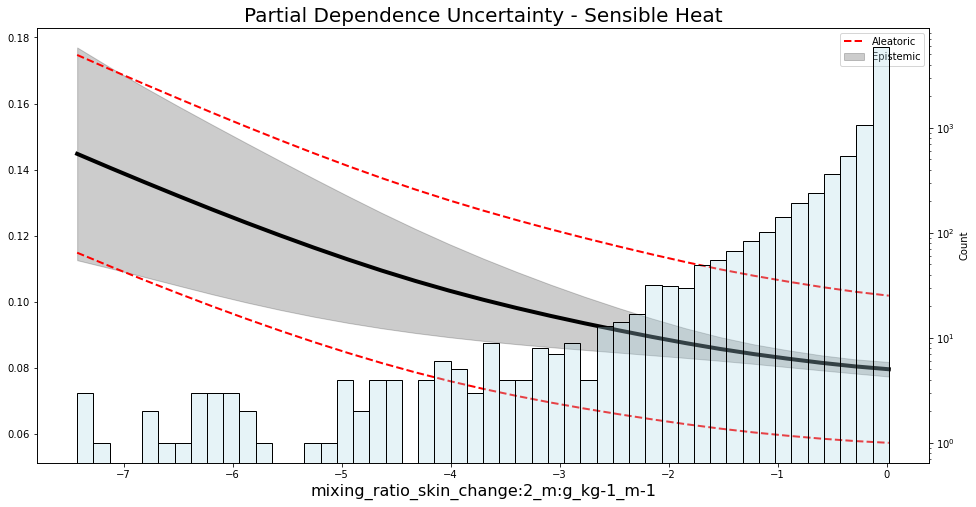

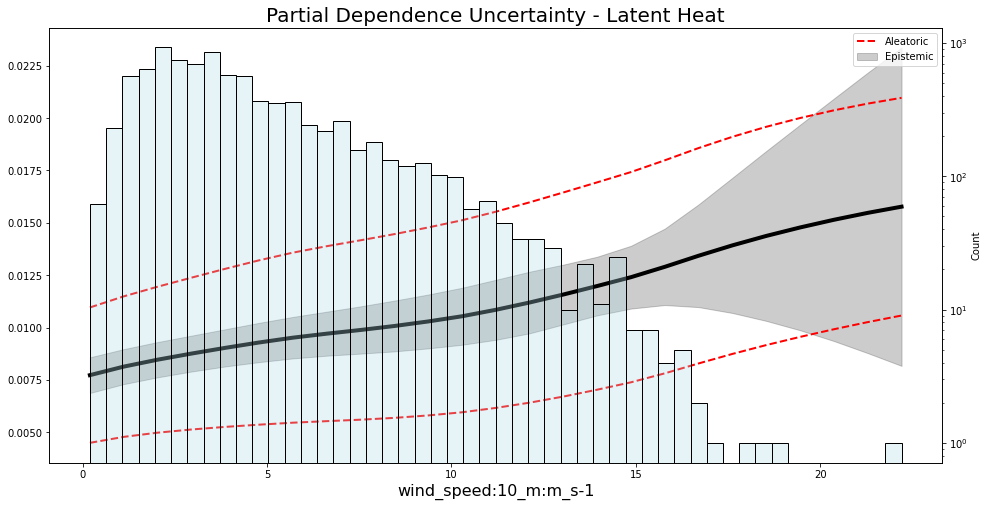

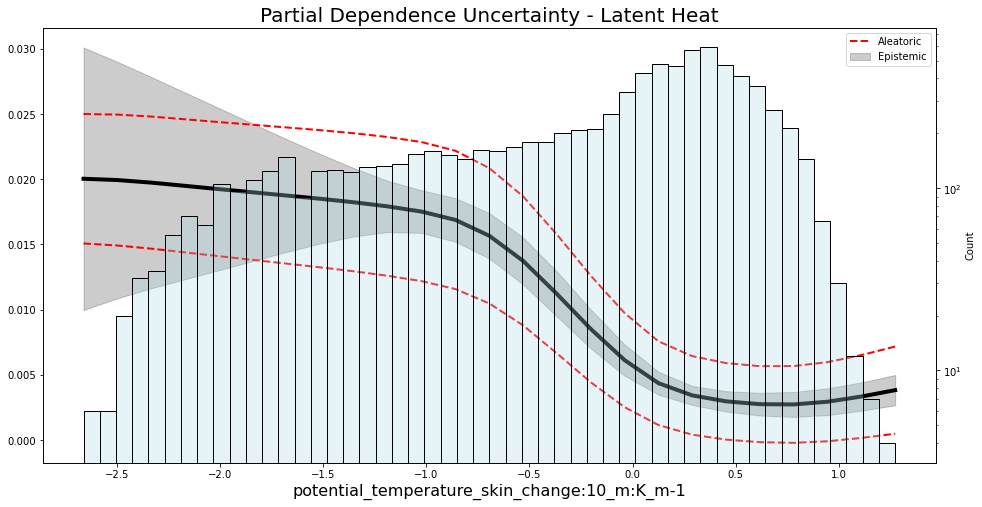

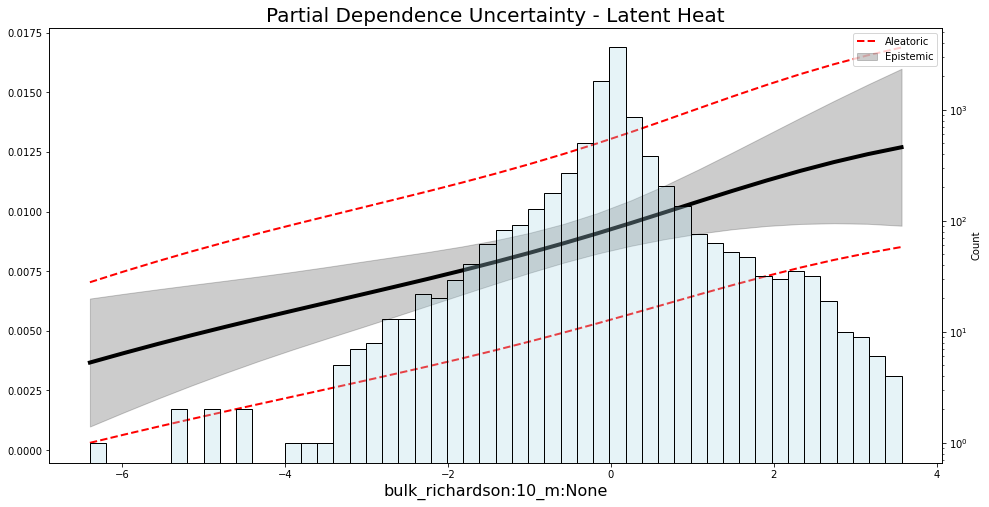

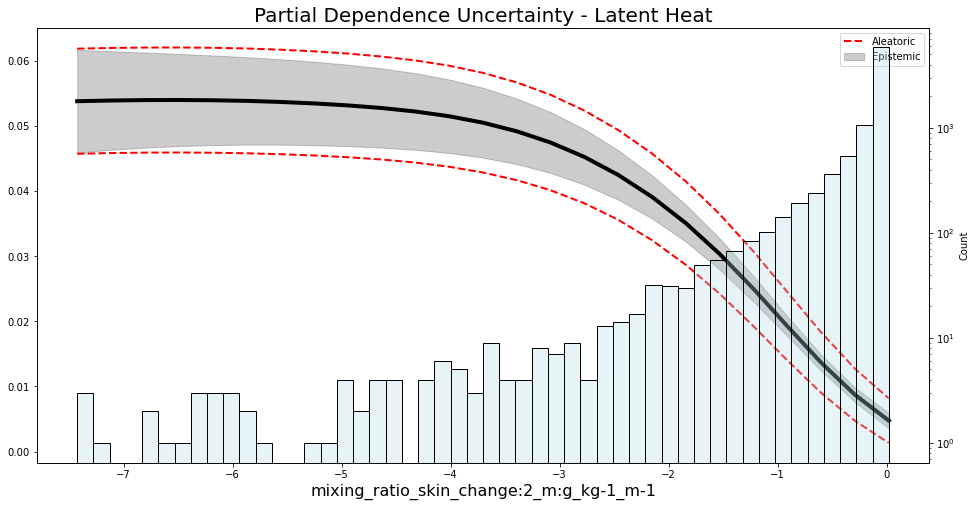

In [116]:
input_cols = ['wind_speed:10_m:m_s-1',
              'potential_temperature_skin_change:10_m:K_m-1',
              'bulk_richardson:10_m:None',
              'mixing_ratio_skin_change:2_m:g_kg-1_m-1']
output_cols = ['friction_velocity:surface:m_s-1', 
               'kinematic_sensible_heat_flux:surface:K_m_s-1', 
               'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']
output_types = ['Friction_velocity', 'Sensible_heat', 'latent_heat']
all_pdps = [FV_pdps, SH_pdps, LH_pdps]
n_members = 30
pdp_uncertainties = np.zeros(shape=(len(output_types), len(input_cols), 25, 2)) 

for index in range(3):
    target = output_cols[index]
    pdps = all_pdps[index]
    output_type = output_types[index]
    
    scaled_data, scalers = preprocess_data(data=data,
                                   input_features=input_cols,
                                   output_features=target,
                                   scaler_type='minmax')
    
    for j, feature in enumerate(input_cols):

        arr = np.zeros(shape=(n_members, 25, 2))
        for i in range(n_members):
            arr[i, :, 0] = scalers['output'].inverse_transform(pdps[f'{feature}_member_{i}']['average'][0].reshape(-1, 1)).flatten()
            sigma = np.sqrt(pdps[f'{feature}_member_{i}']['individual'][1] * data['train'][target].values.var()).mean(axis=0)
            arr[i, :, 1] = sigma
        mean_pdp =  arr[:, :, 0].mean(axis=0)
        aleatoric = arr[:, :, 1].mean(axis=0)
        epistemic = arr[:, :, 0].std(axis=0)
        pdp_uncertainties[index, j, :, 0] = aleatoric
        pdp_uncertainties[index, j, :, 1] = epistemic

        plt.subplots(1, figsize=(16, 8))
        x = np.linspace(data['val'][feature].min(), data['val'][feature].max(), 25) 
        p = sns.lineplot(x=x, y=mean_pdp, color='black', lw=4, linestyle='-')
        sns.lineplot(x=x, y=mean_pdp + aleatoric, color='r', lw=2, linestyle='--',  label='Aleatoric')
        sns.lineplot(x=x, y=mean_pdp - aleatoric, color='r', lw=2, linestyle='--')
        plt.fill_between(x, mean_pdp + epistemic, mean_pdp - epistemic, alpha=0.2, color='k', label='Epistemic')
        plt.legend(loc=1)
        ax2 = p.twinx()
        ax2.set_yscale("log")
        sns.histplot(data['val'][feature], bins=50, color='lightblue', alpha=0.3,
                             label=None)
        p.set_xlabel(feature, fontsize=16)
        plt.title(f"Partial Dependence Uncertainty - {output_type.replace('_', ' ').title()}", fontsize=20)
        # plt.savefig(f'/glade/scratch/cbecker/SL_uncertainty_pdp_{output_type}_{feature.split(":")[0]}.png', dpi=300, bbox_inches='tight')

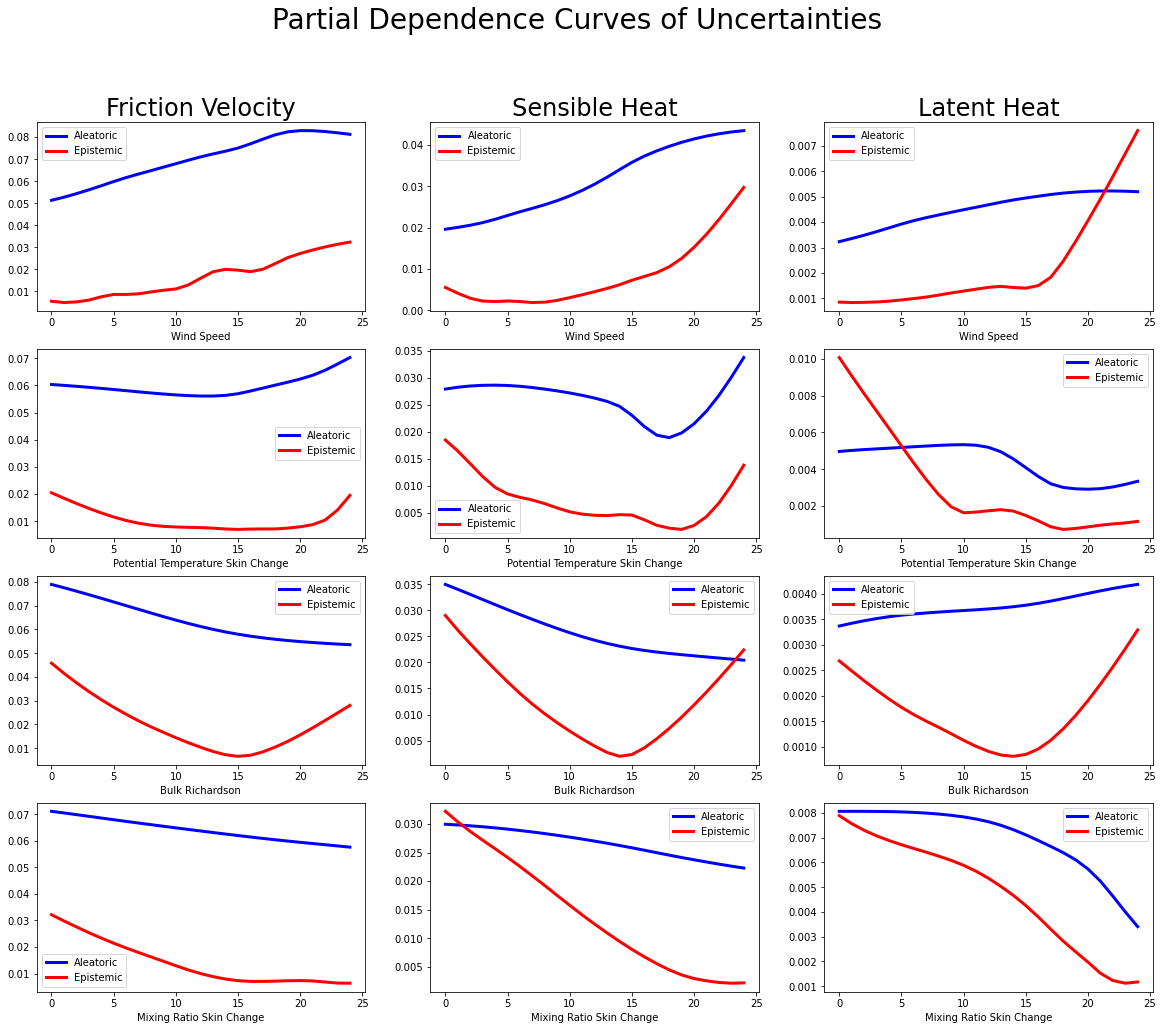

In [135]:
input_cols = ['wind_speed:10_m:m_s-1',
              'potential_temperature_skin_change:10_m:K_m-1',
              'bulk_richardson:10_m:None',
              'mixing_ratio_skin_change:2_m:g_kg-1_m-1']
output_types = ['Friction_velocity', 'Sensible_heat', 'latent_heat']
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
for i, feature in enumerate(input_cols):
    for j, output_type in enumerate(output_types):
        axes[i, j].plot(pdp_uncertainties[j, i, :, 0], color='b', linewidth=3, label='Aleatoric')
        axes[i, j].plot(pdp_uncertainties[j, i, :, 1], color='r', linewidth=3, label='Epistemic')
        axes[i, j].legend()
        axes[i, j].set_xlabel(feature.split(':')[0].replace('_', ' ').title())
        if i == 0:
            axes[i, j].set_title(f"{output_type.replace('_', ' ').title()}", fontsize=24) 
fig.suptitle('Partial Dependence Curves of Uncertainties', fontsize=28)
plt.savefig('/glade/scratch/cbecker/SL_uncertainty_pdps.png', dpi=300, bbox_inches='tight')